Scratch code for generalization to n_variant a/b test + analysis

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.ticker as mtick

from matplotlib import style
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests as mult_test
from tqdm.auto import tqdm

In [127]:
from statsmodels.stats.proportion import binom_test, confint_proportions_2indep, multinomial_proportions_confint, proportions_ztest

In [2]:
# additional imports 
sys.path.append('../../ab_testing_utils/')

In [122]:
import conversion_rate_utils
import sim_utils

In [156]:
from importlib import reload
import itertools

In [241]:
import matplotlib as mpl
from time import gmtime, strftime


In [139]:
reload(conversion_rate_utils)

<module 'conversion_rate_utils' from '/Users/danielokeeffe/Documents/src/stats_utils/stats_utils/notebooks/scratch_work/../../ab_testing_utils/conversion_rate_utils.py'>

In [4]:
# Set pandas preferences
pd.options.display.max_columns=500
pd.options.display.max_colwidth=500
pd.options.display.max_rows=500

In [5]:
# Set plot style
style.use('fivethirtyeight')

In [6]:
# Initialize tqdm for pandas
tqdm.pandas()

We'll continue to work in units of weeks for the experiment run times.  Suppose that we already know the average baseline conversion rate, as well as the average number of daily visitors from historical data. There could be variance in these estimates, but we'll ignore that problem here for now

In [8]:
daily_num_observations = 10000
monthly_num_observations = daily_num_observations * 7 * 4
baseline_conversion_rate = 0.05

In [7]:
number_of_weeks_for_experiment = 4
number_of_days_for_experiment = number_of_weeks_for_experiment * 7

In [167]:
# First, let's estimate how long we actually need to run this for...
mock_exp_design = conversion_rate_utils.ConversionExperiment()

In [169]:
df_mde = mock_exp_design.create_mde_table(monthly_num_obs=monthly_num_observations, baseline_conversion_rate=baseline_conversion_rate, n_variants=5)

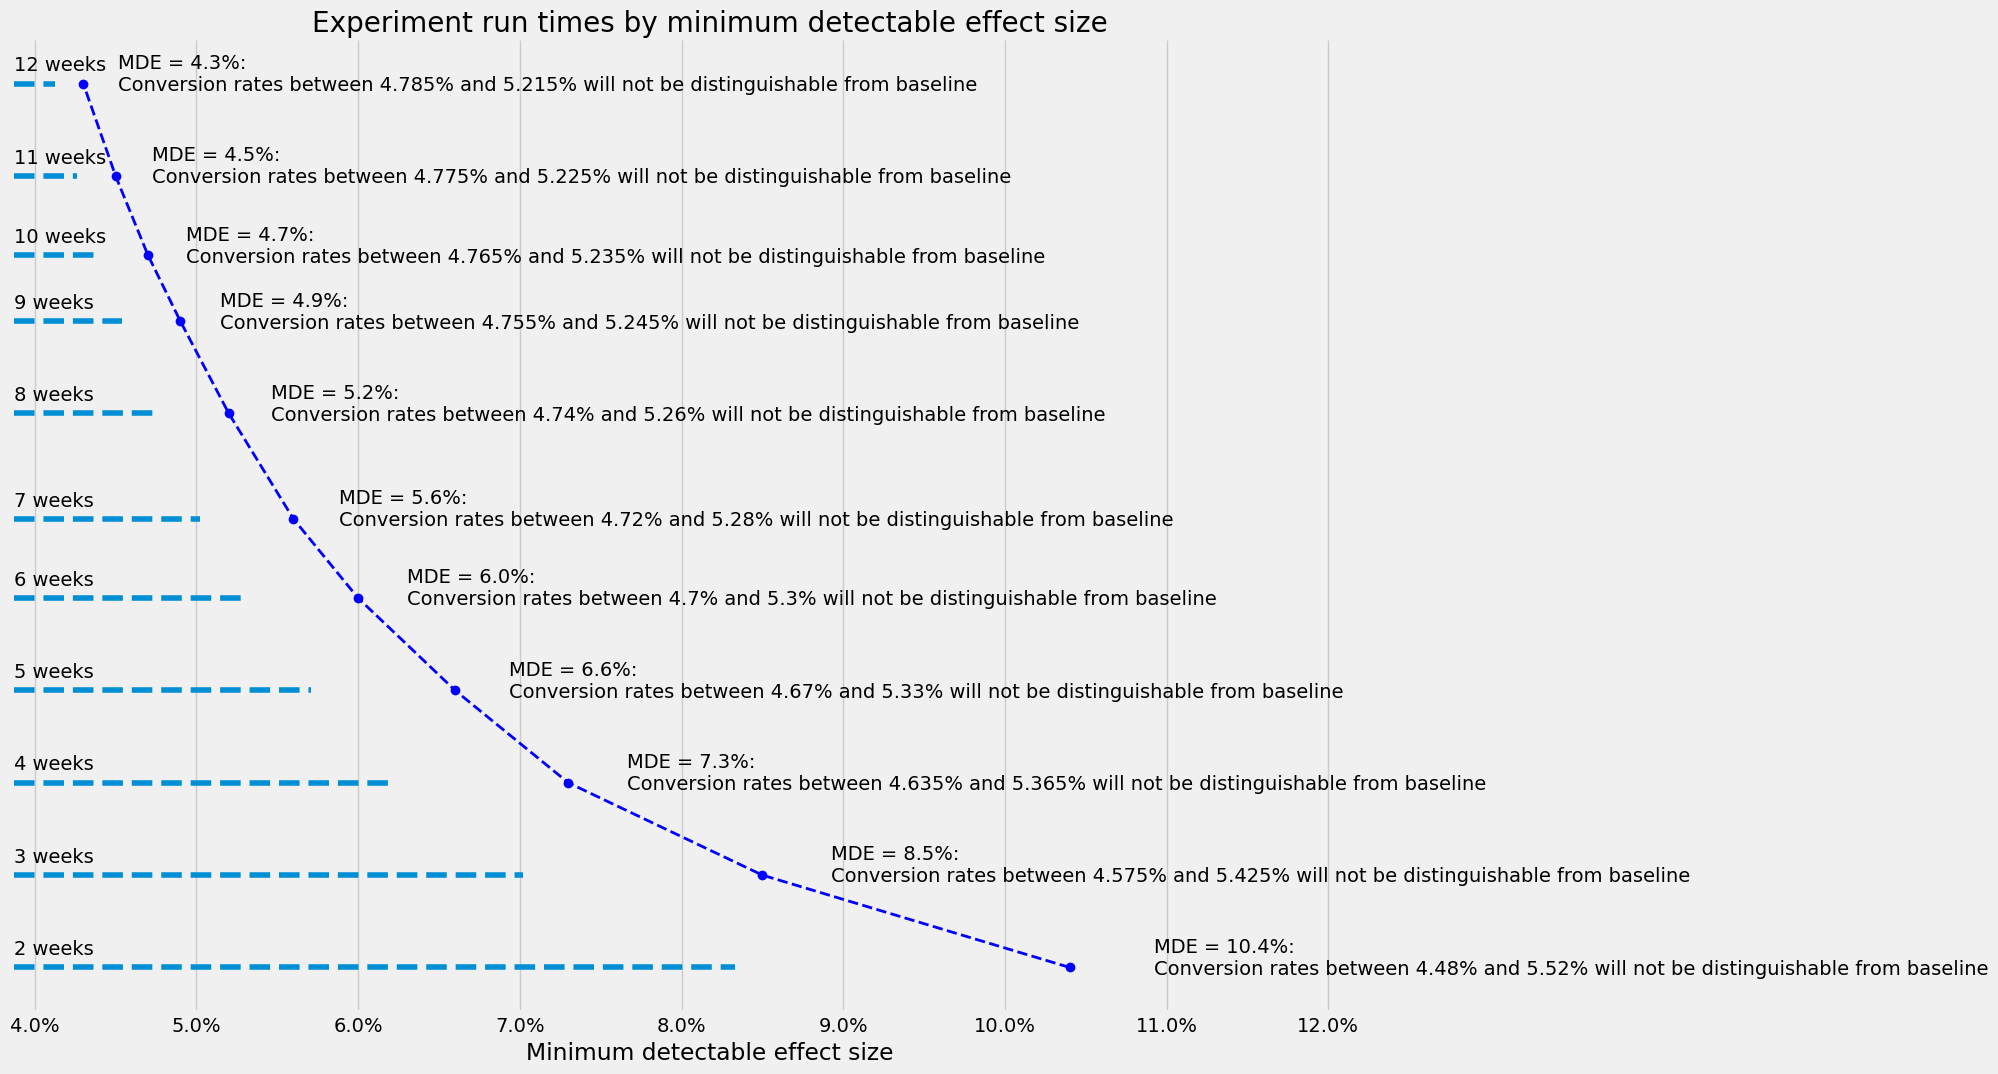

In [171]:
mock_exp_design.make_mde_plot(df_=df_mde, min_weeks=2, max_weeks=12, conservative_runtime=False, figsize=(16,12))

In [172]:
# So in this simplistic design (which is really geared towards a Bonferroni type conversion), 4 weeks would let us distinguish and effect 
# as small as lower than 0.04635, so a true result of 0.048 should not be statistically significantly different, however a difference of 0.01 would be

Simulate a variant test.  We'll have 4 variants (including control). The other three will be statistically significantly larger, the other significantlly smaller, and the third no significant effect. We'll base this on the analysis above. 

In [123]:
sim_ = sim_utils.SimulateABTest()

In [185]:
df_ab = sim_.run_sim(daily_num_observations=daily_num_observations, 
             number_of_days_for_experiment=number_of_days_for_experiment, 
             expected_conversion_rates=[baseline_conversion_rate, 0.06, 0.04, 0.0495], 
             group_col='group', 
             p_vals='equal')

Simulated group sizes: 

control        0.250463
treatment_3    0.250252
treatment_2    0.250188
treatment_1    0.249097
Name: group, dtype: float64


Simulated daily group sizes: 

day  group      
0    treatment_2    0.254504
     control        0.252602
     treatment_3    0.248699
     treatment_1    0.244195
1    control        0.262547
     treatment_3    0.249822
     treatment_1    0.247684
     treatment_2    0.239947
10   treatment_3    0.255109
     control        0.251888
     treatment_2    0.250076
     treatment_1    0.242928
11   control        0.253785
     treatment_3    0.250562
     treatment_1    0.248901
     treatment_2    0.246752
12   treatment_1    0.254715
     treatment_2    0.250149
     control        0.249851
     treatment_3    0.245285
13   control        0.256013
     treatment_3    0.250881
     treatment_2    0.249472
     treatment_1    0.243635
14   control        0.252423
     treatment_2    0.251424
     treatment_1    0.250724
     treatment_3  

In [186]:
df_ab.head()

,day,units,group,conversion_probability,conversion
0,0,1,treatment_1,0.0600,0
1,0,1,control,0.0500,0
2,0,1,treatment_1,0.0600,0
3,0,1,control,0.0500,0
4,0,1,treatment_3,0.0495,0


In [187]:
df_stats = df_ab[['units', 'group', 'conversion']].groupby('group').describe()

In [188]:
df_ab[['group', 'conversion']].groupby('group').sum()

,conversion
group,
control,3584
treatment_1,4242
treatment_2,2818
treatment_3,3475


In [189]:
df_stats.columns = ['_'.join(col).strip().strip('_') for col in df_stats.columns]

In [190]:
df_stats = df_stats.reset_index()

In [191]:
df_stats

,group,units_count,units_mean,units_std,units_min,units_25%,units_50%,units_75%,units_max,conversion_count,conversion_mean,conversion_std,conversion_min,conversion_25%,conversion_50%,conversion_75%,conversion_max
0,control,70222.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,70222.0,0.051038,0.220077,0.0,0.0,0.0,0.0,1.0
1,treatment_1,69839.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,69839.0,0.060740,0.238854,0.0,0.0,0.0,0.0,1.0
2,treatment_2,70145.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,70145.0,0.040174,0.196368,0.0,0.0,0.0,0.0,1.0
3,treatment_3,70163.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,70163.0,0.049528,0.216968,0.0,0.0,0.0,0.0,1.0


In [193]:
# proportions_ztest([9266, 4725], [92985, 93112])
# proportions_ztest([2124, 3503], [69980, 70013])
proportions_ztest([4242, 3584], [69839, 70222])

(7.903926375428157, 2.7025268797693224e-15)

In [194]:
proportions_ztest([2818, 3584], [70145, 70222])

(-9.754660051382137, 1.7618997772591091e-22)

In [195]:
proportions_ztest([3475, 3584], [70163, 70222])

(-1.2950115135594493, 0.19531625770350736)

In [196]:
compare_simple = conversion_rate_utils.ConversionExperiment()
df_simple_ab = compare_simple.simple_ab_test(df=df_ab.loc[(df_ab['group'].isin(['control', 'treatment_1']))], group_column_name='group', control_name='control', treatment_name='treatment_1', outcome_column='conversion', alpha=0.05, null_hypothesis=0)

In [197]:
df_simple_ab

,value
treatment_1_mean,6.073970e-02
treatment_1_confidence_interval_95_percent_lower,5.896824e-02
treatment_1_confidence_interval_95_percent_upper,6.251116e-02
control_mean,5.103814e-02
control_confidence_interval_95_percent_lower,4.941039e-02
control_confidence_interval_95_percent_upper,5.266588e-02
treatment_1_minus_control_mean,9.701565e-03
treatment_1_minus_control_95_percent_lower,7.295816e-03
treatment_1_minus_control_95_percent_upper,1.210731e-02
z_statistic,7.903867e+00


In [198]:
all_variants = df_ab['group'].unique()
treatments_ = [x for x in all_variants if x != 'control']

In [199]:
all_variants

array(['treatment_1', 'control', 'treatment_3', 'treatment_2'],
      dtype=object)

In [200]:
treatments_

['treatment_1', 'treatment_3', 'treatment_2']

In [201]:
list(itertools.product(['control'], treatments_))

[('control', 'treatment_1'),
 ('control', 'treatment_3'),
 ('control', 'treatment_2')]

In [213]:
list_of_dfs = []
for t_ in treatments_:
    df_results_ = compare_simple.simple_ab_test(df=df_ab.loc[(df_ab['group'].isin(['control', t_]))], group_column_name='group', control_name='control', treatment_name=t_, outcome_column='conversion', alpha=0.05, null_hypothesis=0)
    list_of_dfs.append(df_results_.T)

In [214]:
list_of_dfs[1]

,treatment_3_mean,treatment_3_confidence_interval_95_percent_lower,treatment_3_confidence_interval_95_percent_upper,control_mean,control_confidence_interval_95_percent_lower,control_confidence_interval_95_percent_upper,treatment_3_minus_control_mean,treatment_3_minus_control_95_percent_lower,treatment_3_minus_control_95_percent_upper,z_statistic,p_value
value,0.049528,0.047922,0.051133,0.051038,0.04941,0.052666,-0.001511,-0.003797,0.000776,-1.295018,0.195314


In [215]:
# Collect calculated p_values:
p_values = [df_['p_value'].values[0] for df_ in list_of_dfs]

In [216]:
p_values

[2.7038066478129505e-15, 0.19531410062016896, 1.696356213471559e-22]

In [217]:
res_ = mult_test(pvals=p_values, method='bonferroni')

In [218]:
mult_test(pvals=p_values, method='fdr_bh')

(array([ True, False,  True]),
 array([4.05570997e-15, 1.95314101e-01, 5.08906864e-22]),
 0.016952427508441503,
 0.016666666666666666)

In [219]:
res_

(array([ True, False,  True]),
 array([8.11141994e-15, 5.85942302e-01, 5.08906864e-22]),
 0.016952427508441503,
 0.016666666666666666)

In [220]:
for i, df_ in enumerate(list_of_dfs):
    reject_ = res_[0][i]
    p_adj = res_[1][i]
    df_['adjusted_p_value'] = p_adj
    df_['reject_null_hypothesis'] = reject_

In [221]:
list_of_dfs = [df_.T for df_ in list_of_dfs]

In [224]:
# Yeah this should give us the results
list_of_dfs[2]

,value
treatment_2_mean,0.040174
treatment_2_confidence_interval_95_percent_lower,0.038721
treatment_2_confidence_interval_95_percent_upper,0.041627
control_mean,0.051038
control_confidence_interval_95_percent_lower,0.04941
control_confidence_interval_95_percent_upper,0.052666
treatment_2_minus_control_mean,-0.010864
treatment_2_minus_control_95_percent_lower,-0.013046
treatment_2_minus_control_95_percent_upper,-0.008682
z_statistic,-9.758506


In [232]:
def ab_n_variant(df, group_column_name, control_name, outcome_column, alpha, correction_method='bonferroni', null_hypothesis=0, alternative='two_sided'):
    alternatives_ = ['two_sided', 'larger', 'smaller']
    
    assert alternative in alternatives_, "{0} is not a valid alternative. Accepted values are {1}".format(alternative, alternatives_)
    
    # We're going to probably have to assume that all inputs are correct, i.e. that the treatment names are properly defined
    # We can add a few simple sanity checks though
    all_variants = df[group_column_name].unique()
    
    assert len(all_variants) > 1, "More than one variant is required. Input data has: {0}".format(all_variants)
    
    simple_ab_ = conversion_rate_utils.ConversionExperiment()
    
    if len(all_variants) == 2:
        print("Only two variants found, defaulting to simple AB test")
        treatment_name = [x for x in all_variants if x != control_name][0]
        return simple_ab_.simple_ab_test(df=df, 
                                         group_column_name=group_column_name, 
                                         control_name=control_name, 
                                         treatment_name=treatment_name, 
                                         outcome_column=outcome_column, 
                                         alpha=alpha, 
                                         alternative=alternative, 
                                         null_hypothesis=null_hypothesis)
    
    # Test all variants against control.  Collect results and p-values
    treatments_ = [x for x in all_variants if x != control_name]
    
    list_of_dfs = []
    for t_ in treatments_:
        df_results_ = compare_simple.simple_ab_test(df=df.loc[(df[group_column_name].isin([control_name, t_]))], 
                                                    group_column_name=group_column_name, 
                                                    control_name=control_name, 
                                                    treatment_name=t_, 
                                                    outcome_column=outcome_column, 
                                                    alpha=alpha, 
                                                    null_hypothesis=null_hypothesis)
        list_of_dfs.append(df_results_.T)
    
    # Collect calculated p_values:
    p_values = [df_['p_value'].values[0] for df_ in list_of_dfs]
    
    # Adjust p-values for multiple hypothesis testing using require methodology
    res_ = mult_test(pvals=p_values, method=correction_method)
    
    for i, df_ in enumerate(list_of_dfs):
        reject_ = res_[0][i]
        p_adj = res_[1][i]
        df_['adjusted_p_value'] = p_adj
        df_['reject_null_hypothesis'] = reject_
    
    return [df_.T for df_ in list_of_dfs]

In [233]:
results_list = ab_n_variant(df=df_ab, group_column_name='group', control_name='control', outcome_column='conversion', alpha=0.05)

In [238]:
results_list[2]

,value
treatment_2_mean,0.040174
treatment_2_confidence_interval_95_percent_lower,0.038721
treatment_2_confidence_interval_95_percent_upper,0.041627
control_mean,0.051038
control_confidence_interval_95_percent_lower,0.04941
control_confidence_interval_95_percent_upper,0.052666
treatment_2_minus_control_mean,-0.010864
treatment_2_minus_control_95_percent_lower,-0.013046
treatment_2_minus_control_95_percent_upper,-0.008682
z_statistic,-9.758506


In [239]:
list_of_dfs[2]

,value
treatment_2_mean,0.040174
treatment_2_confidence_interval_95_percent_lower,0.038721
treatment_2_confidence_interval_95_percent_upper,0.041627
control_mean,0.051038
control_confidence_interval_95_percent_lower,0.04941
control_confidence_interval_95_percent_upper,0.052666
treatment_2_minus_control_mean,-0.010864
treatment_2_minus_control_95_percent_lower,-0.013046
treatment_2_minus_control_95_percent_upper,-0.008682
z_statistic,-9.758506


In [242]:
# Yep, that does it.  
# How about visualizations now? 
# This should be the same
def add_interval(ax: mpl.axes, xdata: list, ydata: tuple, caps: str, color: str = 'blue', label: str = 'control') -> tuple:
    """
    Function to add and format the intervals for plotting the 95% confidence intervals in the method plot_ab_test_results

    :param ax: The matplotlib ax object to draw the lines on
    :param xdata: List of the lower and upper values of the 95% confidence interval
    :param ydata: List of the y locations to plot the confidence interval line
    :param caps: The style of the caps used to denote the lower and upper limits of the 95% confidence interval
    :param color: The color of the line and caps
    :param label: The label to describe the line

    :return: The line drawn at constant y between the lower and upper limits of the 95% confidence interval, and the annotated caps marking their positions
    """

    line = ax.add_line(mpl.lines.Line2D(xdata, ydata, color=color))
    anno_args = {
        'ha': 'center',
        'va': 'center',
        'size': 24,
        'color': line.get_color()
    }
    a0 = ax.annotate(caps[0], xy=(xdata[0], ydata[0]), **anno_args)
    a1 = ax.annotate(caps[1], xy=(xdata[-1], ydata[-1]), **anno_args)
    line.set_label(label)

    return (line, (a0, a1))

In [248]:
[x for x in list_of_dfs[2].T.columns if 'control' not in x and '_mean' in x and 'minus' not in x][0].split('_mean')[0]

'treatment_2'

In [263]:
def generate_plot_labels(list_of_dfs, control_name, alpha):
    
    label_dict = {}
    
    # generate control labels:
    confidence_level = np.format_float_positional((1-alpha)*100, trim='-')
    control_mean = control_name + '_mean'
    control_lower_p = control_name + '_confidence_interval_{0}_percent_lower'.format(confidence_level)
    control_upper_p = control_name + '_confidence_interval_{0}_percent_upper'.format(confidence_level)
    control_label = "{0}: {1} {2} (CI: {3} - {4})".format(control_name,
                                                     str(np.round(list_of_dfs[0].T[control_mean].values[0] * 100, 4)) + "%",
                                                     confidence_level + '%',
                                                     str(np.round(list_of_dfs[0].T[control_lower_p].values[0] * 100, 4)) + "%",
                                                     str(np.round(list_of_dfs[0].T[control_upper_p].values[0] * 100, 4)) + "%")
    
    label_dict['control'] = {'mean': control_mean, 'lower': control_lower_p, 'upper': control_upper_p, 'label': control_label}
    label_dict['confidence_level'] = confidence_level
    
    for i, df in enumerate(list_of_dfs):
        df_ = df.T
        treatment_name = [x for x in df_.columns if control_name not in x and '_mean' in x and 'minus' not in x][0].split('_mean')[0]
        
        treatment_mean = treatment_name + '_mean'
        treatment_lower_p = treatment_name + '_confidence_interval_{0}_percent_lower'.format(confidence_level)
        treatment_upper_p = treatment_name + '_confidence_interval_{0}_percent_upper'.format(confidence_level)
            
        treatment_label = "{0}: {1} ({2} CI: {3} - {4})".format(treatment_name,
                                                        str(np.round(df_[treatment_mean].values[0] * 100, 4)) + "%",
                                                                confidence_level + '%',
                                                        str(np.round(df_[treatment_lower_p].values[0] * 100, 4)) + "%",
                                                        str(np.round(df_[treatment_upper_p].values[0] * 100, 4)) + "%")
        
        label_dict[treatment_name] = {'mean': treatment_mean, 'lower': treatment_lower_p, 'upper': treatment_upper_p, 'label': treatment_label, 'df_index': i}
    
    return label_dict

In [264]:
test_label_dict = generate_plot_labels(list_of_dfs=list_of_dfs, control_name='control', alpha=0.05)

In [265]:
test_label_dict

{'control': {'mean': 'control_mean',
  'lower': 'control_confidence_interval_95_percent_lower',
  'upper': 'control_confidence_interval_95_percent_upper',
  'label': 'control: 5.1038% 95% (CI: 4.941% - 5.2666%)'},
 'confidence_level': '95',
 'treatment_1': {'mean': 'treatment_1_mean',
  'lower': 'treatment_1_confidence_interval_95_percent_lower',
  'upper': 'treatment_1_confidence_interval_95_percent_upper',
  'label': 'treatment_1: 6.074% (95% CI: 5.8968% - 6.2511%)',
  'df_index': 0},
 'treatment_3': {'mean': 'treatment_3_mean',
  'lower': 'treatment_3_confidence_interval_95_percent_lower',
  'upper': 'treatment_3_confidence_interval_95_percent_upper',
  'label': 'treatment_3: 4.9528% (95% CI: 4.7922% - 5.1133%)',
  'df_index': 1},
 'treatment_2': {'mean': 'treatment_2_mean',
  'lower': 'treatment_2_confidence_interval_95_percent_lower',
  'upper': 'treatment_2_confidence_interval_95_percent_upper',
  'label': 'treatment_2: 4.0174% (95% CI: 3.8721% - 4.1627%)',
  'df_index': 2}}

In [259]:
for group_, label_dict_ in test_label_dict.items():
    if group_ == 'confidence_level':
        pass
    else:
        if group_ == 'control':
            df_ = list_of_dfs[0]
        else:
            df_ == list_of_dfs[label_dict_['df_index']]
        

control
{'mean': 'control_mean', 'lower': 'control_confidence_interval_95_percent_lower', 'upper': 'control_confidence_interval_95_percent_upper', 'label': 'control: 95% 5.1038% CI: 4.941% - 5.2666%)'}
treatment_1
{'mean': 'treatment_1_mean', 'lower': 'treatment_1_confidence_interval_95_percent_lower', 'upper': 'treatment_1_confidence_interval_95_percent_upper', 'label': 'treatment_1: 95% (6.074% CI: 5.8968% - 6.2511%)', 'df_index': 0}
treatment_3
{'mean': 'treatment_3_mean', 'lower': 'treatment_3_confidence_interval_95_percent_lower', 'upper': 'treatment_3_confidence_interval_95_percent_upper', 'label': 'treatment_3: 95% (4.9528% CI: 4.7922% - 5.1133%)', 'df_index': 1}
treatment_2
{'mean': 'treatment_2_mean', 'lower': 'treatment_2_confidence_interval_95_percent_lower', 'upper': 'treatment_2_confidence_interval_95_percent_upper', 'label': 'treatment_2: 95% (4.0174% CI: 3.8721% - 4.1627%)', 'df_index': 2}
